# DeepMatter Data Science/Cheminformatician Interview Notebook

This Jupyter notebook contains tasks to be completed prior to your second interview, and is expected to take
2-3 hours. Please complete it as necessary and be prepared to discuss it at the interview. Code should be
completed using Python, unless a viable/better/justifiable alternative exists.

## Environmental Setup

Projects in DeepMatter are structured using Anaconda and Pipenv. As these questions will
make use of RDKit, Anaconda is the preferred virtual environment setup. Before you continue,
please install Anaconda and create an environment named "dm_interview".

## Task 1 - Runtime Sensor Data

Clone the `dm_datascience` repository located on Github at
https://github.com/deepmatterltd/dm_datascience, and unzip the data located under
`02_PCML_and_PCRR/data/pcrr.zip`.

PCRR (Practical Chemistry Runtime Record) files are an XML-based method of capturing all data
associated with a chemistry run in our product DigitalGlassware. They capture things such as the
operations associated with the reaction, the reagents, the product, the final yield and other outcomes.
They also contain observations such as textual and photo notes, as well as timestamps associated
with when each operation was performed (e.g. *add 5mg of catalyst X to reactor vessel*).

0. Download and Extract Data

In [1]:
import zipfile
import os

# === clone repo ===
dm_datascience_repo_dir = "../dm_datascience"
if not os.path.isdir(dm_datascience_repo_dir): # only clone if the directory doesn't exist already
    !git clone https://github.com/deepmatterltd/dm_datascience $dm_datascience_repo_dir


# === extract zip file from repo ===
zip_file_path = os.path.join(dm_datascience_repo_dir, "02_PCML_and_PCRR", "data", "pcrr.zip") # location of target zip file
pccr_dir = os.path.join("..", "pcrr") # target extraction directory

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(pccr_dir)

# === export enviroment ===
!conda env export --from-history > environment.yml

import matplotlib.pyplot as plt
%matplotlib inline

1. For each of the PCRR files in the run, extract the name of the recipe, author and number of
operations in the recipe.

In [2]:
import dm_PCCRParse as PCCRParse
import dm_utils as utils
import importlib
importlib.reload(PCCRParse)
importlib.reload(utils)

for recipe in utils.process_directory(pccr_dir, PCCRParse.get_pccr_metadata):
    print(recipe)

RDKit WARNING: [17:42:53] Enabling RDKit 2019.09.3 jupyter extensions


3a_run_02.pcrr: 3a) Synthesis of N-(1-Naphthoyl)-4-methylbenzenesulfonohydrazide by Deepmatter with 84 operations.
3a_run_03.pcrr: 3a) Synthesis of N-(1-Naphthoyl)-4-methylbenzenesulfonohydrazide by Deepmatter with 84 operations.
3a_run_01.pcrr: 3a) Synthesis of N-(1-Naphthoyl)-4-methylbenzenesulfonohydrazide by Deepmatter with 84 operations.


2. XML is great for explicitly structuring data, but not much fun to handle for signal processing.
Write a function which can take in a PCRR filename and sensor name (e.g. `irObjTempI` for immersed temperature, or
`uvaI` for immersed UVA level) and returns the data a Pandas Series of length N. Note that each sensor
reading in the XML has a timestamp associated with it. This timestamp should also be parsed and assigned
to the index of the Series object returned.

In [3]:
# === Get irObjTempI data ===
file_path = "../pcrr/3a_run_01.pcrr"

stop_after_first = False
sensor_names = "irObjTempI"
df_sensor_data = PCCRParse.extract_sensor_data(file_path, sensor_names, stop_after_first)
print(df_sensor_data[sensor_names])

                         irObjTempI
timestamp                          
2019-02-18 08:56:42.056   16.717920
2019-02-18 08:56:42.933   16.706354
2019-02-18 08:56:43.859   16.706354
2019-02-18 08:56:44.737   16.694818
2019-02-18 08:56:45.663   16.738123
...                             ...
2019-02-19 09:00:17.033   22.152338
2019-02-19 09:00:17.959   22.174738
2019-02-19 09:00:18.885   22.183130
2019-02-19 09:00:19.763   22.171930
2019-02-19 09:00:20.641   22.188715

[91255 rows x 1 columns]


3. Use the function to extract immersed temperature (`irObjTempI`) and plot against time.

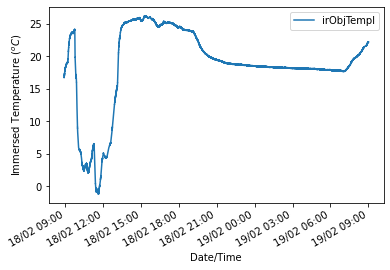

In [4]:
# === Plot irObjTempI data ===
sensor_plot_label = "Immersed Temperature ($^oC$)" # assume celsius, defintely not kelvin (<0)
fig = PCCRParse.plot_sensor_data(df_sensor_data[sensor_names], sensor_plot_label)

4. Compute the rolling median of the immersed temperature, with a window of 30 seconds, and plot it.
Overlay the rolling median of the immersed UVA trace (`uvaI`) on the same plot.

In [5]:
# === Get UvaI (and irObjTempI) data ===
sensor_names = ["uvaI", "irObjTempI"]
df_sensor_data = PCCRParse.extract_sensor_data(file_path, sensor_names, stop_after_first)

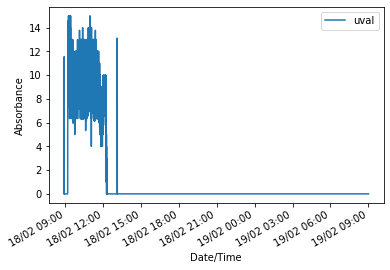

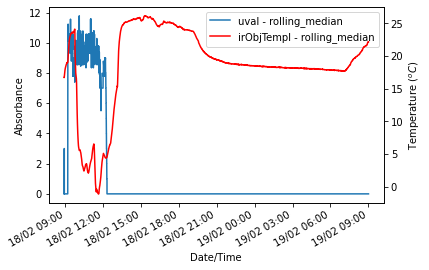

In [6]:
# === Plot uvaI ===
fig = PCCRParse.plot_sensor_data(df_sensor_data["uvaI"], "Absorbance")

# === Calculate rolling medians ===
rolling_window = 30 # rolling window size in seconds
for sensor_name in sensor_names:
    df_sensor_data[sensor_name][f"{sensor_name} - rolling_median"] = df_sensor_data[sensor_name][sensor_name].rolling(f'{rolling_window}s').median()

# === Plot uvaI and irObjTempI Side by Side ===
fig = PCCRParse.plot_sensor_data(df_sensor_data["uvaI"][f"uvaI - rolling_median"], 
    "Absorbance",
    df_sensor_data["irObjTempI"][f"irObjTempI - rolling_median"],
    "Temperature ($^oC$)")

## Task 2 - Reaction Data

While PCRR is used as a means of encapsulating chemistry runs in DigitalGlassware, the concept
 of using XML as a structuring mechanism is quite recent. There are many older datasets which
 use formats such as RDF, wherein lists of reactions describe the structural change which
 occurs during the chemistry. This section will focus on a small sample dataset which uses
 this format

To perform this task, install [RDKit](https://www.rdkit.org) to your Anaconda environment.

An RD file has been provided under the `data` directory for use in the following tasks.

1. Write a parser to split up `data/spresi-100.rdf` into `$RXN` blocks, which
denote individual reactions. A valid reaction starts with `$RXN` and includes
every subsequent line until the next `$RXN` block (inclusive) or the
end of the file.
Everything before the first `$RXN` block can be ignored.
<p>
Alternatively, there is a Python library which will do this for you, but it's up to you
to find it.


In [7]:
import dm_RDFParse as RDFParse
importlib.reload(RDFParse)
file_path = "../data/spresi-100.rdf"
rxn_blocks = RDFParse.extract_reactions(file_path)
print(f"Found {len(rxn_blocks)+1} reactions.")

Found 100 reactions.


2. Use RDKit to parse each of the `$RXN` text blocks you parsed in above,
 and print out the SMILES for the reagents and products
 on the first 5 reactions.


In [8]:
molecules = RDFParse.get_molecules_from_rxn_list(rxn_blocks)
RDFParse.print_SMILES_from_molecule_list(molecules)

reactant: O=S(C1=CC=CC=C1)[CH:2]1[C:1]2([O:3]1)[CH2:4][CH2:7][CH:11]([C:14]([CH3:17])([CH3:18])[CH3:19])[CH2:8][CH2:5]2
reactant: O=Cl(=O)(=O)[O-].[Li+]
reactant: CCCCP(=O)(CCCC)CCCC
product: [C:1]1([CH:2]=[O:3])=[CH:4][CH2:7][CH:11]([C:14]([CH3:17])([CH3:18])[CH3:19])[CH2:8][CH2:5]1
reactant: [H][C@:2]12[C@@:1]([CH3:5])([CH:3]([C@@:9]([H])([CH2:13][CH2:17][CH2:21][CH:24]([CH3:26])[CH3:27])[CH3:14])[CH2:8][CH2:7]1)[CH2:4][CH2:10][C@@:11]1([H])[C@@:6]2([H])[CH2:12][CH2:16][C@:18]2([H])[C@:15]1([CH3:20])[CH2:19][CH2:23][C:25]([CH:28](Cl)[S:30]([C:32]1=[CH:34][CH:36]=[CH:38][CH:37]=[CH:35]1)=[O:33])([OH:29])[CH2:22]2
reactant: [H][O-].[K+]
product: [H][C@:2]12[C@@:1]([CH3:5])([CH:3]([C@@:9]([H])([CH2:13][CH2:17][CH2:21][CH:24]([CH3:26])[CH3:27])[CH3:14])[CH2:8][CH2:7]1)[CH2:4][CH2:10][C@@:11]1([H])[C@@:6]2([H])[CH2:12][CH2:16][C@:18]2([H])[C@:15]1([CH3:20])[CH2:19][CH2:23][C:25]1([CH2:22]2)[CH:28]([S:30]([C:32]2=[CH:34][CH:36]=[CH:38][CH:37]=[CH:35]2)=[O:33])[O:29]1
reactant: Cl[C:11]([C:

2. Generate [molecular fingerprints](https://www.rdkit.org/docs/GettingStartedInPython.html#morgan-fingerprints-circular-fingerprints)
for all reagents and products and store them in a binary numpy matrix (bonus: use a sparse matrix).
Use a radius of 2 and fingerprint length of 1000. Ignore any molecules which throw an exception, and remove them from
the final array.

In [36]:
import dm_dimensionality_reduction as dr
importlib.reload(dr)

nbits = 1000
fingerprints = dr.get_molecular_fingerprints(molecules, nbits)
fingerprints

<20x1000 sparse matrix of type '<class 'numpy.int8'>'
	with 333 stored elements in Compressed Sparse Row format>

3. Perform dimensionality reduction on the fingerprints to visualise the data in 2D.
Use whether the molecule's fingerprint was a reactant or product as the colour of the point.

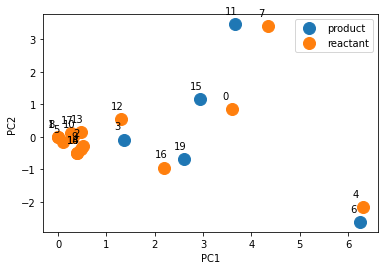

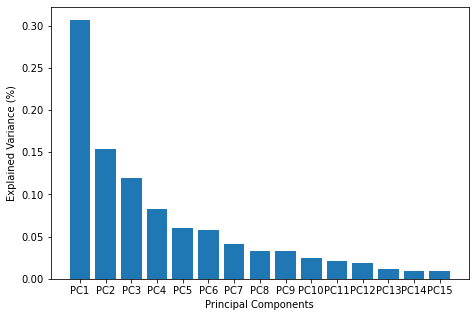

In [47]:
from sklearn.decomposition import TruncatedSVD
import pandas as pd

num_components = 15

# === Perform Dimentionality Reduction ===
tSVD = TruncatedSVD(num_components) # tSVD rather than PCA for sparse matrix
fingerprints_tSVD = tSVD.fit_transform(fingerprints)

# === Convert to Dataframe ===
column_names = dr.generate_column_names("PC", num_components)
true_labels = [molecule.mol_type for molecule in molecules]
df_fingerprints_tSVD = dr.reduced_dimensions_to_df(fingerprints_tSVD, true_labels, column_names)

# === Plot 2D Scatterplot ===
fig_svd, ax_svd = plt.subplots()
ax_svd = dr.get_axes(df_fingerprints_tSVD, ax_svd)

# === Scree Plot ===
fig_scree = dr.scree_plot(num_components, tSVD, columns)

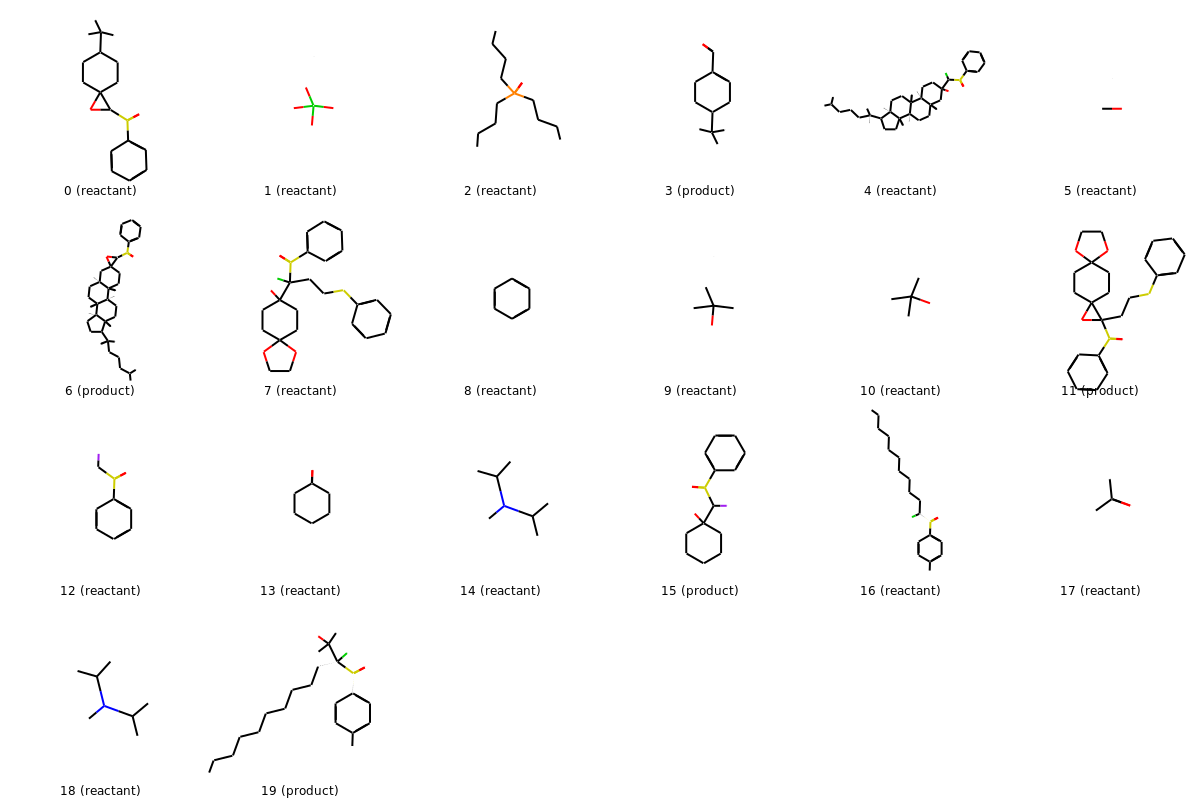

In [42]:
from rdkit.Chem import Draw

# === Visualise Molecules ===
mols_per_row = 6
legends = [f"{str(ii)} ({type})" for ii, type in enumerate([mol.mol_type for mol in molecules])] # get the molecule types for the legened
img = Draw.MolsToGridImage([mol.mol for mol in molecules], legends=legends, molsPerRow=mols_per_row)
img

Perform clustering on the fingerprints and visualise the results in the same embedding used
in the previous question.

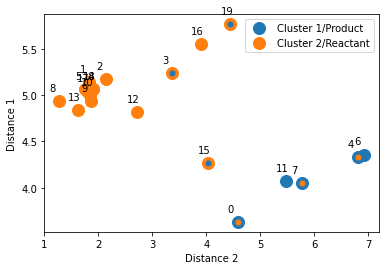

In [43]:
from sklearn.cluster import KMeans

# === kmeans clustering ===
n_clusters = 2 # reactants and products
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
fingerprints_kmean = kmeans.fit_transform(fingerprints)

# === Convert to Dataframe ===
column_names = dr.generate_column_names("Distance ", n_clusters)
cluster_labels = kmeans.predict(fingerprints)+1 # cluster the molecule belongs to
df_fingerprints_kmean = dr.reduced_dimensions_to_df(fingerprints_kmean, cluster_labels, column_names)
df_fingerprints_kmean["molecule_type"] = true_labels

# === Plot 2D Scatterplot ===
fig_kmean, ax_kmean = plt.subplots()
ax_kmean = dr.get_axes(df_fingerprints_kmean, ax_kmean, marker="o", switch_xy=True) # predicted cluster
ax_kmean = dr.get_axes(df_fingerprints_kmean, ax_kmean, "molecule_type", marker="o", markersize = 5, switch_xy=True, label_idx=False) # add the true labels, will appear as smaller markers within the predicted cluster marker
ax_kmean.legend(["Cluster 1/Product", "Cluster 2/Reactant"])

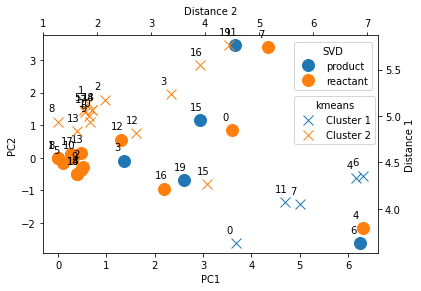

In [46]:
# === Plot SVD and k-means together ===

fig = plt.figure() # place two plots on top of each other
ax_svd_m = fig.add_subplot(111, label="pca")

ax_svd_m.set_xlabel('PC1')  
ax_svd_m.set_ylabel('PC2')

ax_kmeans_m = fig.add_subplot(111, label="kmeans", frame_on=False)
ax_kmeans_m.xaxis.tick_top()
ax_kmeans_m.yaxis.tick_right()
ax_kmeans_m.set_xlabel('Distance C2') 
ax_kmeans_m.set_ylabel('Distance C1')
ax_kmeans_m.xaxis.set_label_position('top') 
ax_kmeans_m.yaxis.set_label_position('right') 

ax_kmeans_m = dr.get_axes(df_fingerprints_kmean, ax_kmeans_m, marker="x", markersize=10, switch_xy=True)
ax_svd_m = dr.get_axes(df_fingerprints_tSVD, ax_svd_m)

ax_svd_m.legend(title="SVD", loc=[0.75, 0.75])
ax_kmeans_m.legend(["Cluster 1", "Cluster 2"], title="kmeans", loc=[0.75, 0.5])

## Wrap Up

Please bring the completed code in this notebook/code for generating results along to your interview.
The code should be executed in real-time unless there is a good reason to avoid this. You will be
asked how you completed the tasks and why you did it a certain way, as well as discussion
on other ways the tasks could have been performed.

